In [1]:
!pip install torch torchvision matplotlib -q

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

# Шаг 2: Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # стандартная нормализация MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Разделение на train/val
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)  # batch=1 для атак

print(f"Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 515kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]


Train: 50000, Val: 10000, Test: 10000


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [4]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

def train_model(model, device, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

train_model(model, device, train_loader, optimizer, criterion, epochs=5)


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/5, Loss: 0.2470
Epoch 2/5, Loss: 0.0944
Epoch 3/5, Loss: 0.0686
Epoch 4/5, Loss: 0.0560
Epoch 5/5, Loss: 0.0493


In [5]:
def fgsm_attack(data, epsilon, data_grad):
    perturbed_data = data + epsilon * data_grad.sign()
    return torch.clamp(perturbed_data, 0, 1)

def ifgsm_attack(data, epsilon, data_grad, steps=10):
    alpha = epsilon / steps
    perturbed = data
    for _ in range(steps):
        perturbed = perturbed + alpha * data_grad.sign()
        perturbed = torch.clamp(perturbed, 0, 1)
        if torch.norm(perturbed - data, p=float('inf')) > epsilon:
            break
    return perturbed

def mifgsm_attack(data, epsilon, data_grad, steps=10, decay=1.0):
    g = torch.zeros_like(data_grad)
    alpha = epsilon / steps
    perturbed = data
    for _ in range(steps):
        g = decay * g + data_grad / torch.norm(data_grad, p=1)
        perturbed = perturbed + alpha * g.sign()
        perturbed = torch.clamp(perturbed, 0, 1)
        if torch.norm(perturbed - data, p=float('inf')) > epsilon:
            break
    return perturbed


In [6]:
# Тест с атаками
def test_attack(model, device, test_loader, epsilon, attack_type="fgsm"):
    correct = 0
    adv_examples = []
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        if attack_type == "fgsm":
            perturbed = fgsm_attack(data, epsilon, data_grad)
        elif attack_type == "ifgsm":
            perturbed = ifgsm_attack(data, epsilon, data_grad)
        elif attack_type == "mifgsm":
            perturbed = mifgsm_attack(data, epsilon, data_grad)
        else:
            perturbed = data

        output = model(perturbed)
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
    accuracy = correct / float(len(test_loader))
    print(f"Epsilon: {epsilon:.3f} → Accuracy: {accuracy:.2%}")
    return accuracy, adv_examples



--- FGSM ---
Epsilon: 0.000 → Accuracy: 97.93%
Epsilon: 0.007 → Accuracy: 97.91%
Epsilon: 0.010 → Accuracy: 97.89%
Epsilon: 0.020 → Accuracy: 97.84%
Epsilon: 0.030 → Accuracy: 97.81%
Epsilon: 0.050 → Accuracy: 97.64%
Epsilon: 0.100 → Accuracy: 97.43%
Epsilon: 0.200 → Accuracy: 96.72%
Epsilon: 0.300 → Accuracy: 95.89%


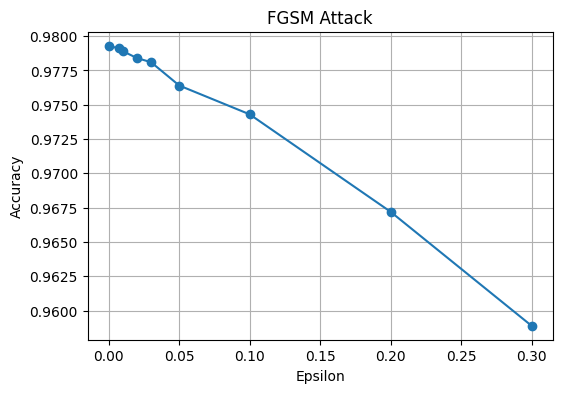


--- IFGSM ---
Epsilon: 0.000 → Accuracy: 97.93%
Epsilon: 0.007 → Accuracy: 97.93%
Epsilon: 0.010 → Accuracy: 97.93%
Epsilon: 0.020 → Accuracy: 97.93%
Epsilon: 0.030 → Accuracy: 97.92%
Epsilon: 0.050 → Accuracy: 97.92%
Epsilon: 0.100 → Accuracy: 97.89%
Epsilon: 0.200 → Accuracy: 97.84%
Epsilon: 0.300 → Accuracy: 97.81%


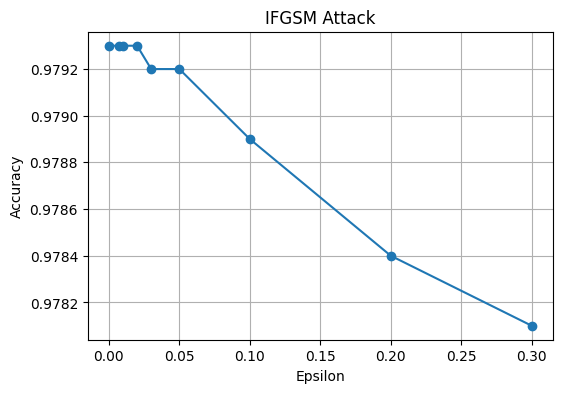


--- MIFGSM ---
Epsilon: 0.000 → Accuracy: 97.93%
Epsilon: 0.007 → Accuracy: 97.93%
Epsilon: 0.010 → Accuracy: 97.93%
Epsilon: 0.020 → Accuracy: 97.93%
Epsilon: 0.030 → Accuracy: 97.92%
Epsilon: 0.050 → Accuracy: 97.92%
Epsilon: 0.100 → Accuracy: 97.89%
Epsilon: 0.200 → Accuracy: 97.84%
Epsilon: 0.300 → Accuracy: 97.81%


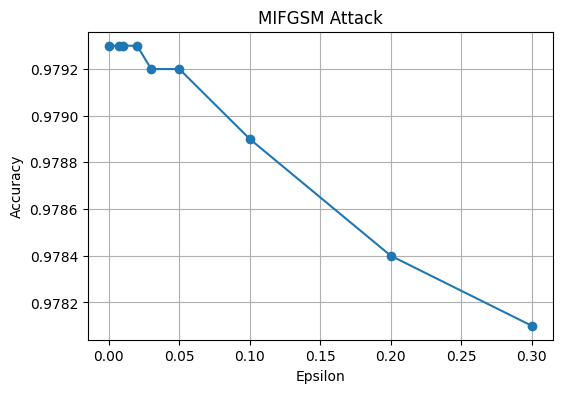

In [7]:
epsilons = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
attack_types = ["fgsm", "ifgsm", "mifgsm"]

results = {}
for attack in attack_types:
    print(f"\n--- {attack.upper()} ---")
    accuracies = []
    all_examples = []
    for eps in epsilons:
        acc, ex = test_attack(model, device, test_loader, eps, attack)
        accuracies.append(acc)
        if eps == epsilons[-1]:
            all_examples = ex
    results[attack] = (accuracies, all_examples)

    # График точности
    plt.figure(figsize=(6, 4))
    plt.plot(epsilons, accuracies, 'o-')
    plt.title(f"{attack.upper()} Attack")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

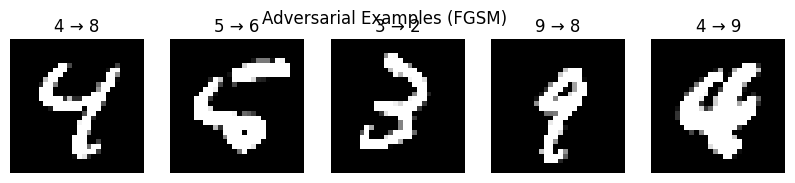

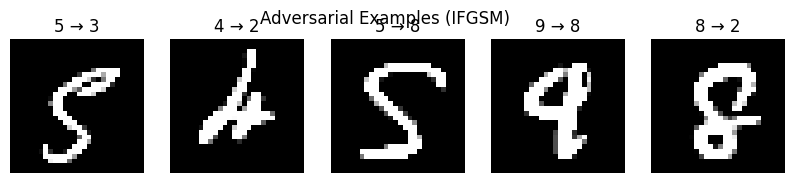

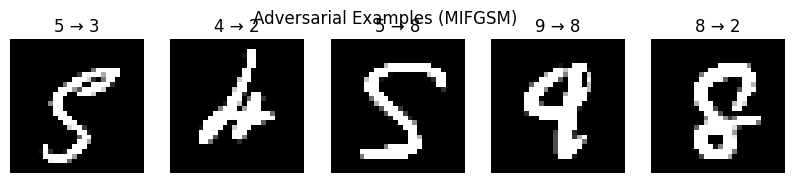

In [8]:
for attack in attack_types:
    _, examples = results[attack]
    plt.figure(figsize=(10, 2))
    for i, (orig, adv, ex) in enumerate(examples):
        plt.subplot(1, len(examples), i+1)
        plt.title(f"{orig} → {adv}")
        plt.imshow(ex, cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Adversarial Examples ({attack.upper()})")
    plt.show()

In [9]:
# Модели для дистилляции
class NetF(nn.Module):
    def __init__(self):
        super(NetF, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # без softmax!

class NetF1(nn.Module):
    def __init__(self):
        super(NetF1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
def defensive_distillation(device, train_loader, test_loader, T=100, epochs=5):
    print("Обучение Teacher-модели (NetF)...")
    teacher = NetF().to(device)
    opt_teacher = optim.Adam(teacher.parameters(), lr=0.001)

    # Обучаем teacher
    for epoch in range(epochs):
        teacher.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            opt_teacher.zero_grad()
            output = teacher(data)
            soft_labels = F.log_softmax(output / T, dim=1)
            hard_loss = F.cross_entropy(output, target)
            hard_loss.backward()
            opt_teacher.step()

    print("Генерация мягких меток...")
    soft_dataset = []
    teacher.eval()
    with torch.no_grad():
        for data, target in train_loader:
            data = data.to(device)
            soft_logits = teacher(data)
            soft_labels = F.softmax(soft_logits / T, dim=1)
            for i in range(data.size(0)):
                soft_dataset.append((data[i].cpu(), soft_labels[i].cpu()))

    soft_loader = torch.utils.data.DataLoader(soft_dataset, batch_size=128, shuffle=True)

    print("Обучение Student-модели (NetF1) на мягких метках...")
    student = NetF1().to(device)
    opt_student = optim.Adam(student.parameters(), lr=0.001)
    criterion = nn.KLDivLoss(reduction='batchmean')

    for epoch in range(epochs):
        student.train()
        for data, soft_target in soft_loader:
            data, soft_target = data.to(device), soft_target.to(device)
            opt_student.zero_grad()
            student_logits = student(data)
            student_log_prob = F.log_softmax(student_logits / T, dim=1)
            loss = criterion(student_log_prob, soft_target)
            loss.backward()
            opt_student.step()

    return student

# Обучение защищённой модели
protected_model = defensive_distillation(device, train_loader, test_loader, T=50, epochs=3)


Обучение Teacher-модели (NetF)...
Генерация мягких меток...
Обучение Student-модели (NetF1) на мягких метках...


In [11]:
print("\n--- Тест защищённой модели (Defensive Distillation) ---")
for attack in ["fgsm", "ifgsm", "mifgsm"]:
    print(f"\n{attack.upper()} на защищённой модели:")
    for eps in [0.1, 0.2, 0.3]:
        test_attack(protected_model, device, test_loader, eps, attack)


--- Тест защищённой модели (Defensive Distillation) ---

FGSM на защищённой модели:
Epsilon: 0.100 → Accuracy: 96.94%
Epsilon: 0.200 → Accuracy: 96.46%
Epsilon: 0.300 → Accuracy: 95.96%

IFGSM на защищённой модели:
Epsilon: 0.100 → Accuracy: 97.27%
Epsilon: 0.200 → Accuracy: 97.23%
Epsilon: 0.300 → Accuracy: 97.18%

MIFGSM на защищённой модели:
Epsilon: 0.100 → Accuracy: 97.27%
Epsilon: 0.200 → Accuracy: 97.23%
Epsilon: 0.300 → Accuracy: 97.18%
